<a href="https://colab.research.google.com/github/Shinyu-Mao/Simple-Keyword-Search-with-Python/blob/main/Performance_Optimisation_for_Simple_Keyword_Search.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Functional Test

Loading data


In [2]:
!git clone https://github.com/Shinyu-Mao/Simple-Keyword-Searching-with-Python.git

Cloning into 'Simple-Keyword-Searching-with-Python'...
remote: Enumerating objects: 7, done.
remote: Counting objects: 100% (7/7), done.
remote: Compressing objects: 100% (6/6), done.
remote: Total 7 (delta 0), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (7/7), done.


In [1]:
from IPython.core.display import display, HTML

In [39]:
class MySearchV0():
  """
  Base class for Search Engine.

  ...

  Attributes
  ----------
  filename : str 
      file name of doc data

  Methods
  --------
  load_data(filename):
      load data from file.
  highlight(text, keyword):
      highlight text with keyword.
  score(text, keyword):
      get score of text for a query.
  search(keyword):
      get search result of a query.
  render(result_list, keyword):
      output search results with highlight.
  """
  
  def __init__(self, filename:str):
        self.docs = []
        self.load_data(filename)
    
  def load_data(self, filename:str):
      with open(filename, "r", encoding="utf-8") as f:
          self.docs = f.read().split('\n')
  
  def search(self, keyword:str):
      """return a list of sorted news title index"""
      result_score=[]
      for idx, title in enumerate(self.docs):
          if keyword.lower() in title.lower():
              result_score.append((idx, self.score(title, keyword)))
      result_score = sorted(result_score, key=lambda x:x[1], reverse=True)
      sorted_result= [idx for idx,_ in result_score]
      return sorted_result

  def render(self, result_score:list, keyword:str):
      """print the highlighted result in html"""
      index=1
      for sorted_idx in result_score:
          display(HTML(f'{index}. {self.highlight(self.docs[sorted_idx], keyword)}'))
          index+=1

  def highlight(self, text:str, keyword:str):
      """highlight the keywords in each hited title"""
      hl_result = text
      k_index = text.lower().find(keyword.lower())
      if k_index >=0:
          origin_kword = text[k_index:k_index+ len(keyword)]
          hl_result = text.replace(origin_kword, f'<span style="color:red"> {origin_kword} </span>')
      return hl_result

  def score(self, text:str, keyword:str):
      """count keywords in each title"""
      count = text.lower().count(keyword.lower())
      return count



In [8]:
%cd Simple-Keyword-Searching-with-Python/

/content/Simple-Keyword-Searching-with-Python


In [40]:
keyword = "Queensland"
searcher = MySearchV0("9news_headlines.txt")
search_result = searcher.search(keyword)
searcher.render(search_result, keyword)

# Performance Test with Simple Data Multiplication

In [105]:
class MySearchV1(MySearchV0):
  """
  V0: Base class for Search Engine.
  V1: Data multiplication added.

  ...

  Attributes
  ----------
  filename : str 
      file name of doc data
  multi_factor : int
      data multiplication factor(default 1)

  Methods
  --------
  load_data(filename):
      load data from file.
  highlight(text, keyword):
      highlight text with keyword.
  score(text, keyword):
      get score of text for a query.
  search(keyword):
      get search result of a query.
  render(result_list, keyword):
      output search results with highlight.
  """
  
  def __init__(self, filename:str, multi_factor=1):
        self.docs = []
        self.multi_factor = multi_factor #data multiplication
        self.load_data(filename)
    
  def load_data(self, filename:str):
      with open(filename, "r", encoding="utf-8") as f:
          self.docs = f.read().split('\n')
      self.docs = self.docs * self.multi_factor #simple data multiplication


In [106]:
help(MySearchV1)

Help on class MySearchV1 in module __main__:

class MySearchV1(MySearchV0)
 |  MySearchV1(filename: str, multi_factor=1)
 |  
 |  V0: Base class for Search Engine.
 |  V1: Data multiplication added.
 |  
 |  ...
 |  
 |  Attributes
 |  ----------
 |  filename : str 
 |      file name of doc data
 |  multi_factor : int
 |      data multiplication factor(default 1)
 |  
 |  Methods
 |  --------
 |  load_data(filename):
 |      load data from file.
 |  highlight(text, keyword):
 |      highlight text with keyword.
 |  score(text, keyword):
 |      get score of text for a query.
 |  search(keyword):
 |      get search result of a query.
 |  render(result_list, keyword):
 |      output search results with highlight.
 |  
 |  Method resolution order:
 |      MySearchV1
 |      MySearchV0
 |      builtins.object
 |  
 |  Methods defined here:
 |  
 |  __init__(self, filename: str, multi_factor=1)
 |      Initialize self.  See help(type(self)) for accurate signature.
 |  
 |  load_data(self, f

Test on the cost of time for search

In [117]:
searcher = MySearchV1("9news_headlines.txt", 50000)

In [118]:
#search in around 2,000,000 news titles
keyword = 'Queensland'
%time search_result = searcher.search(keyword)

CPU times: user 968 ms, sys: 1.59 ms, total: 969 ms
Wall time: 971 ms


Performance Bottleneck Analysis

In [120]:
%prun search_result = searcher.search(keyword)

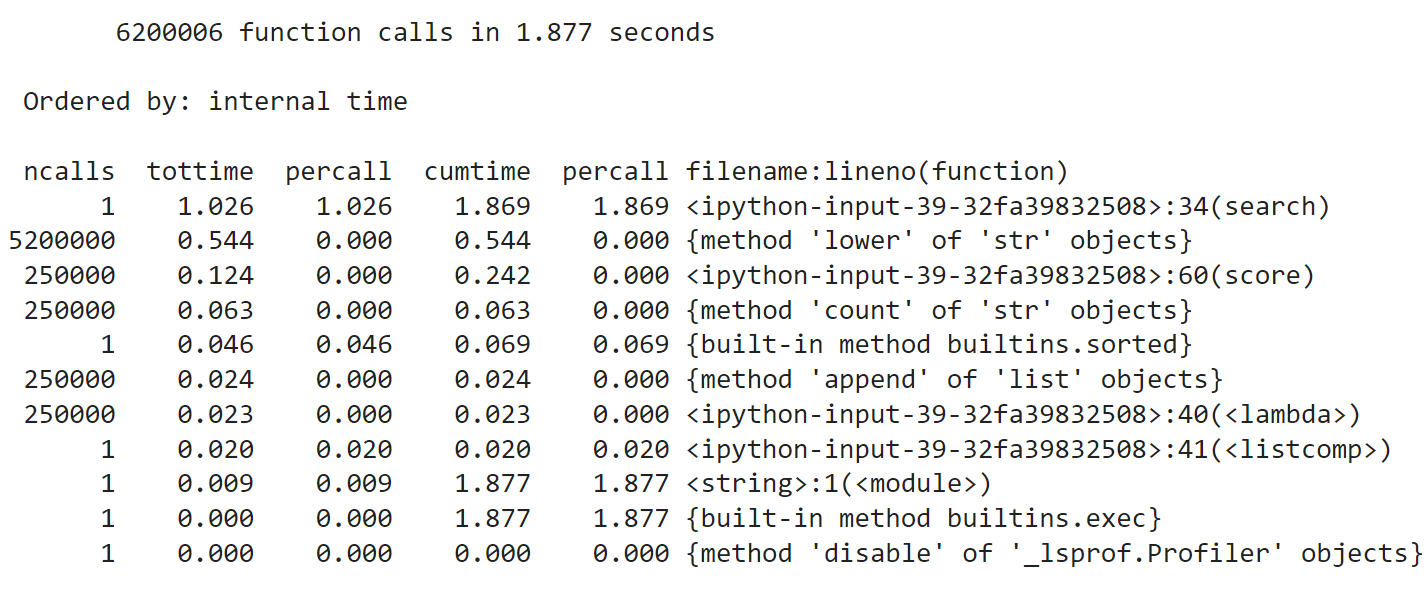

We can identify the cost mainly comes from `lower()`, `count()`, `sort()`

Consider improvement from three aspects:
- function realisation
- structure design
- data volume

Optimisation for `sort()`: Divide-and-Conquer


Only keep the docs with score larger than the lowest one  

In [121]:
import bisect

class MySearchV2(MySearchV1):
  """
  V0: Base class for Search Engine.
  V1: Data multiplication added.
  V2: Sorting optimization.

  ...

  Attributes
  ----------
  filename : str 
      file name of doc data
  multi_factor : int
      data multiplication factor(default 1)

  Methods
  --------
  load_data(filename):
      load data from file.
  highlight(text, keyword):
      highlight text with keyword.
  score(text, keyword):
      get score of text for a query.
  search(keyword):
      get search result of a query.
  render(result_list, keyword):
      output search results with highlight.

  """

  def search(self, keyword, num=15):
      """restrict the results in num and build optimisation based on it"""
      result_list=[]
      min_score = 0
      for tid, title in enumerate(self.docs):
          if keyword.lower() in title.lower():
            score = self.score(title, keyword)
            if len(result_list) == num:
              if score > min_score:
                insert_idx = bisect.bisect(
                    [doc_score[1] for doc_score in result_list], score
                )
                min_score = result_list[0][1]
                result_list = result_list[1:insert_idx] + [(tid, score)] + result_list[insert_idx:]
            elif len(result_list) < num-1:
              result_list.append((tid, score))
            elif len(result_list) == num-1:
              result_list.append((tid, score))
              result_list.sort(key = lambda x:x[1])
              min_score = result_list[0][1]
      return [doc_id for doc_id,_ in result_list[::-1]]

In [122]:
searcher = MySearchV2("9news_headlines.txt", 50000)

In [126]:
#search in around 2,000,000 news titles
keyword = 'Queensland'
%time search_result = searcher.search(keyword)

CPU times: user 801 ms, sys: 0 ns, total: 801 ms
Wall time: 804 ms


In [125]:
%prun search_result = searcher.search(keyword)

Optimisation for `count()`: Indexing


Optimisation for `lower()`: Trade space for time

Pre-lowercasing/Caching the docs.

In [127]:
class MySearchV3(MySearchV1):
  """
  V0: Base class for Search Engine.
  V1: Data multiplication added.
  V2: Sorting optimization.
  V3: Add lowercased version of docs.

  ...

  Attributes
  ----------
  filename : str 
      file name of doc data
  multi_factor : int
      data multiplication factor(default 1)

  Methods
  --------
  load_data(filename):
      load data from file.
  highlight(text, keyword):
      highlight text with keyword.
  score(text, keyword):
      get score of text for a query.
  search(keyword):
      get search result of a query.
  render(result_list, keyword):
      output search results with highlight.

  """
  def __init__(self, filename, multi_factor=1):
        self.docs = []
        self.docs_lower = []
        self.multi_factor = multi_factor #data multiplication
        self.load_data(filename)
    
  def load_data(self, filename):
      with open(filename, "r", encoding="utf-8") as f:
          self.docs = f.read().split('\n')
      self.docs_lower = [doc.lower() for doc in self.docs]
      self.docs = self.docs * self.multi_factor
      self.docs_lower = self.docs_lower * self.multi_factor 

  def highlight(self, text, keyword, origin_text):
      """highlight the keywords in each hited title"""
      idx = text.find(keyword)
      result = text
      if idx >=0:
          origin_kword = origin_text[idx:idx + len(keyword)]
          result = origin_text.replace(origin_kword, f'<span style="color:red"> {origin_kword} </span>')
      return result

  def score(self, text, keyword):
      """count keywords in each title"""
      count = text.count(keyword)
      return count

  def search(self, keyword, num=15):
      """restrict the results in num and build optimisation based on it"""
      result_list=[]
      min_score = 0
      keyword_lower = keyword.lower()
      for tid, title in enumerate(self.docs_lower):
          if keyword_lower in title:
            score = self.score(title, keyword_lower)
            if len(result_list) == num:
              if score > min_score:
                insert_idx = bisect.bisect(
                    [doc_score[1] for doc_score in result_list], score
                )
                min_score = result_list[0][1]
                result_list = result_list[1:insert_idx] + [(tid, score)] + result_list[insert_idx:]
            elif len(result_list) < num-1:
              result_list.append((tid, score))
            elif len(result_list) == num-1:
              result_list.append((tid, score))
              result_list.sort(key = lambda x:x[1])
              min_score = result_list[0][1]
      return [doc_id for doc_id,_ in result_list[::-1]]

  def render(self, result_list, keyword):
    """print the highlighted result in html"""
    count = 1
    for item in result_list:
        result = self.highlight(self.docs_lower[item], keyword.lower(), self.docs[item])
        display(HTML(f"{count}, {result}"))
        count += 1

In [129]:
searcher = MySearchV3("9news_headlines.txt", 50000)

In [130]:
#search in around 2,000,000 news titles
keyword = 'Queensland'
%time search_result = searcher.search(keyword)

CPU times: user 348 ms, sys: 0 ns, total: 348 ms
Wall time: 357 ms


In [131]:
%prun search_result = searcher.search(keyword)

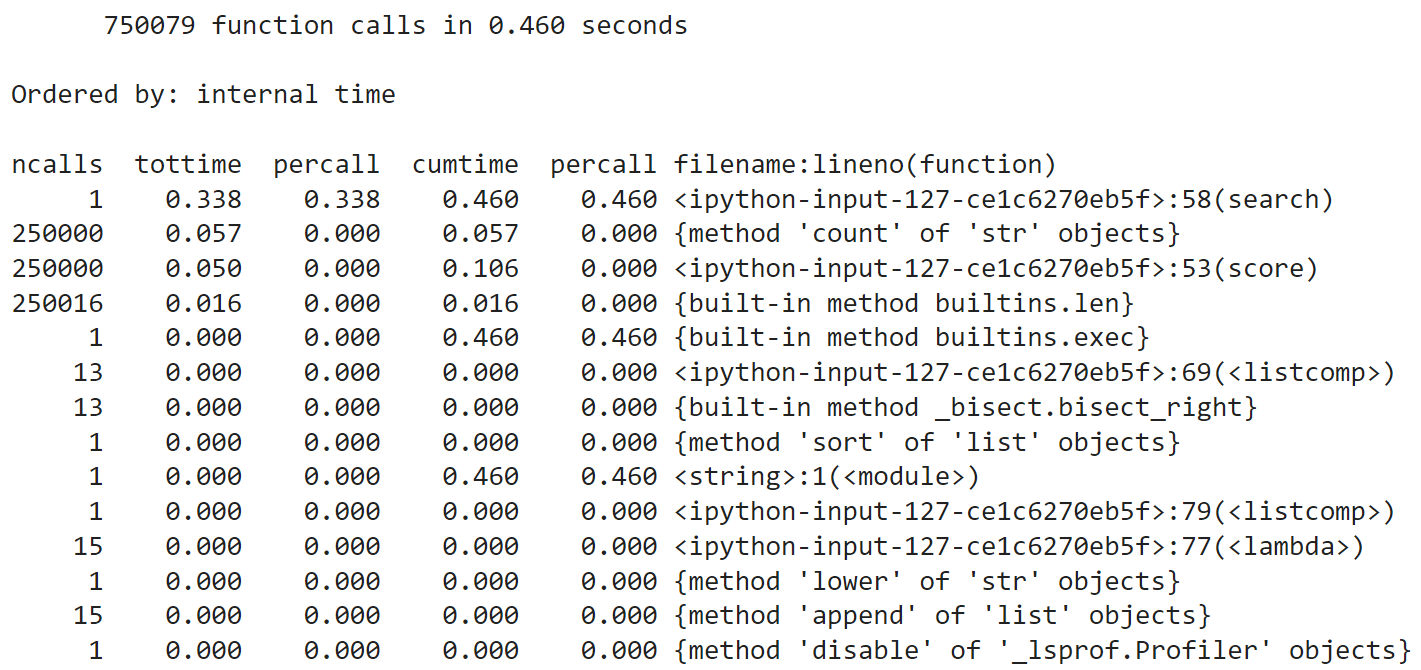

After optimising the "search once" case, considering search for multiple times

In [133]:
keyword = 'Queensland'
%time search_result = searcher.search(keyword)
%time search_result = searcher.search(keyword)

CPU times: user 359 ms, sys: 0 ns, total: 359 ms
Wall time: 361 ms
CPU times: user 348 ms, sys: 0 ns, total: 348 ms
Wall time: 350 ms


Reduce the cost for repetitive requests for the same task

Cache the recent results